In [1]:
import sys
import os
import time

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from util import CompetitionModel
from copy import deepcopy

import numpy as np
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
# from scipy.integrate.odepack import ODEintWarning
from scipy.integrate import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

# Seed the random number generators for reproducibility
np.random.seed(0)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


from util import create_datasets, export_coefficients, export_mse_mae, export_thereshold
from plot import plot_models
from pysindy.feature_library import CustomLibrary
from plot import plot_pareto


In [2]:
output_path = "Compare_with_SciANN"
if not os.path.isdir(output_path):
    os.makedirs(output_path)
    
tag = "FD"

Competition with Survival
Training [0,10] noise level = 0.05

0.04040404040404041 0.24242424242424243
(u)' = 0.460 u + -0.160 u^2 + -0.170 u v
(v)' = -0.289 v + -0.185 u v + 0.168 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[0, 10]\coefs_FD_0.05_100_[0, 10].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[0, 10]\threshold_FD_0.05_100_[0, 10].csv


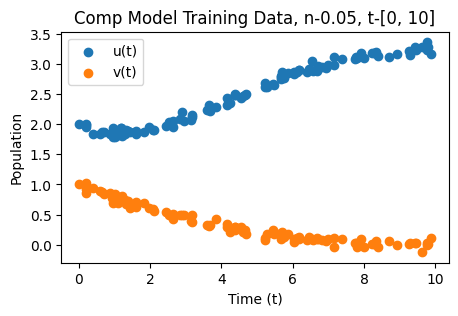

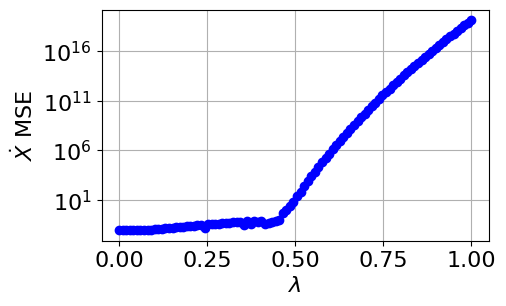

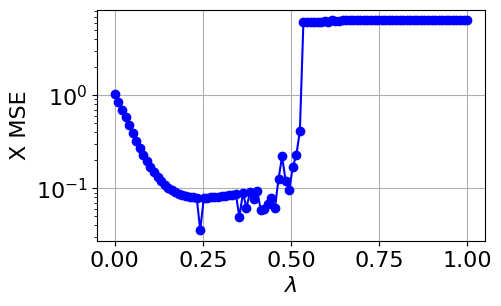

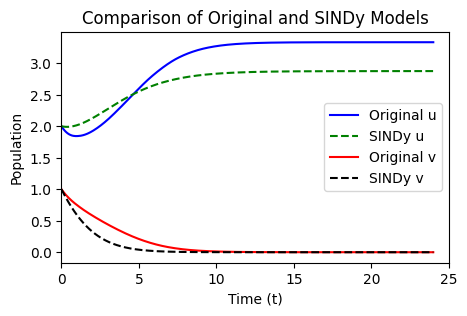

In [3]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [0, 10]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       save_path=plot_save_path,
                                                       sparse=sparse)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', 
                                trimming_fraction=0.33)
                                #max_iter=100)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.23, thresholder='l2', 
                              trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Competition with Survival
Training [0, 24] noise level = 0.05

0.23232323232323235 0.24242424242424243
(u)' = 0.480 u + -0.149 u^2 + -0.194 u v
(v)' = -0.026 v + -0.213 u v + 0.191 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[0, 24]\coefs_FD_0.05_100_[0, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[0, 24]\threshold_FD_0.05_100_[0, 24].csv


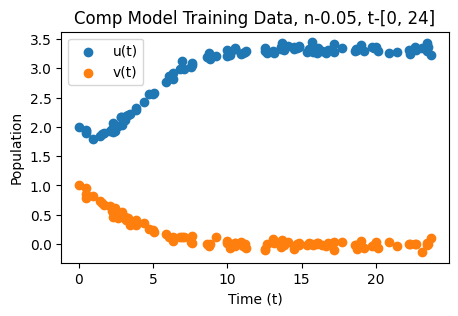

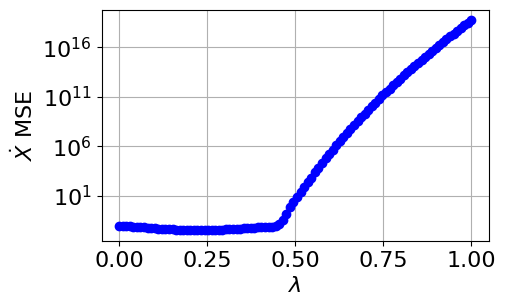

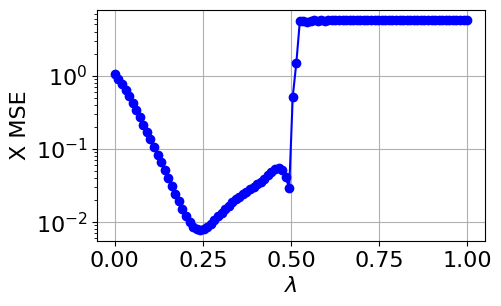

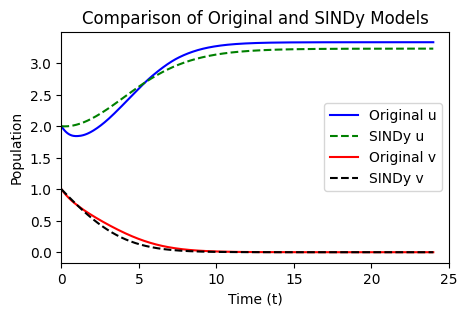

In [4]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [0, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       save_path= plot_save_path,
                                                       sparse=sparse)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

# Ensemble gives better result in this case. Try commenting out with ensemble=False, and see the difference
for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', 
                                trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, ensemble=False, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.24, thresholder='l2', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)


# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Competition with Survival
Training [10, 24] noise level = 0.05

0.08080808080808081 0.10101010101010102
(u)' = 0.200 u + -0.061 u^2 + 0.047 u v
(v)' = -0.012 v + -0.043 u v + -0.008 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[10, 24]\coefs_FD_0.05_100_[10, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.05_FD_100_500_[10, 24]\threshold_FD_0.05_100_[10, 24].csv


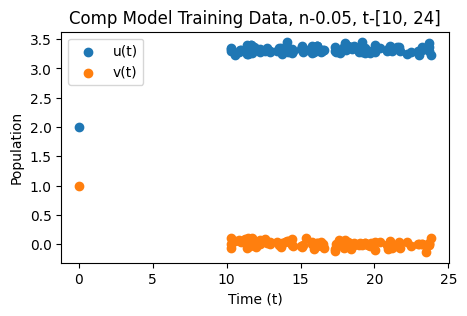

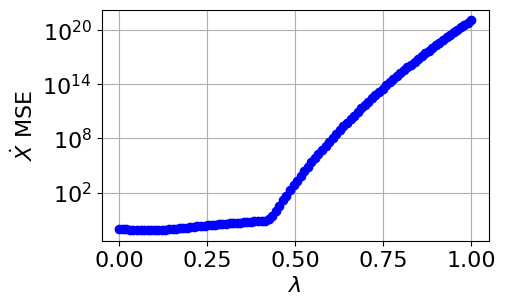

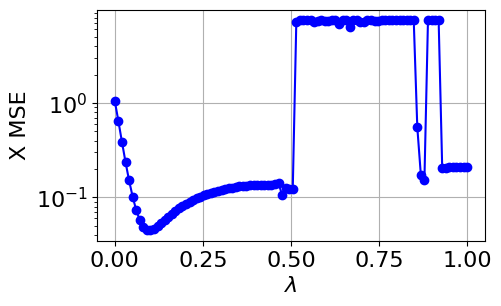

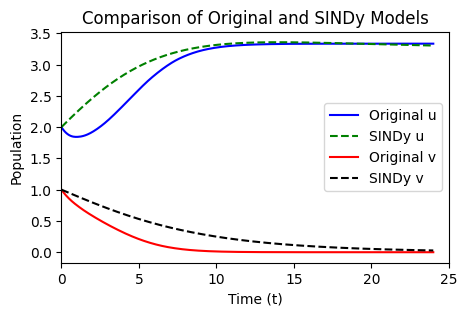

In [5]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [10, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       save_path=plot_save_path,
                                                       sparse=sparse)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.1, thresholder='l2', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

# Noise set to 0.005

Training [0,10] noise 0.005

0.393939393939394 0.4040404040404041
(u)' = 0.800 u + -0.245 u^2 + -0.452 u v
(v)' = -0.034 v + -0.177 u v + 0.100 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[0, 10]\coefs_FD_0.005_100_[0, 10].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[0, 10]\threshold_FD_0.005_100_[0, 10].csv


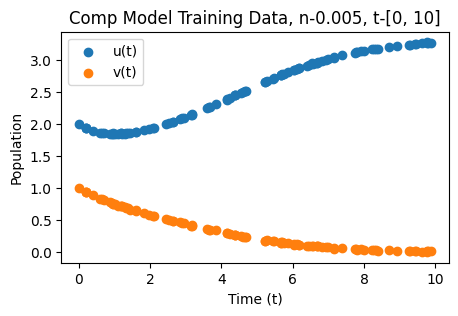

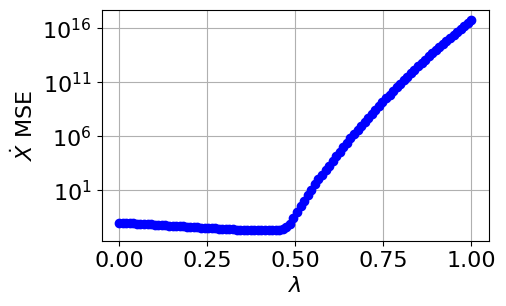

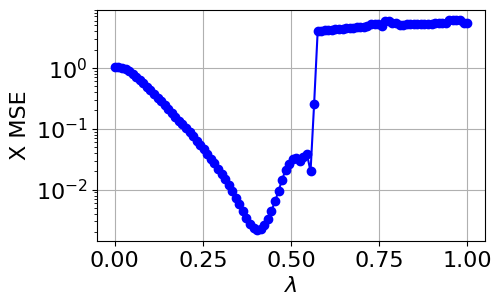

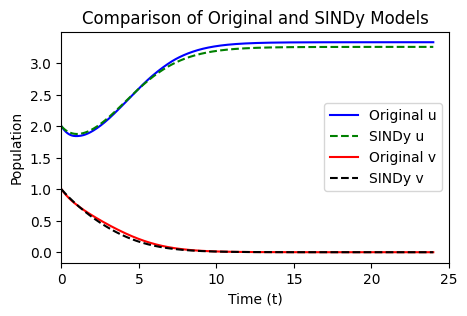

In [6]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [0, 10]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       save_path=plot_save_path,
                                                       sparse=sparse)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.4, thresholder='l2', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training [0,24] noise = 0.005

0.43434343434343436 0.4141414141414142
(u)' = 0.820 u + -0.247 u^2 + -0.462 u v
(v)' = -0.014 v + -0.158 u v + 0.053 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[0, 24]\coefs_FD_0.005_100_[0, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[0, 24]\threshold_FD_0.005_100_[0, 24].csv


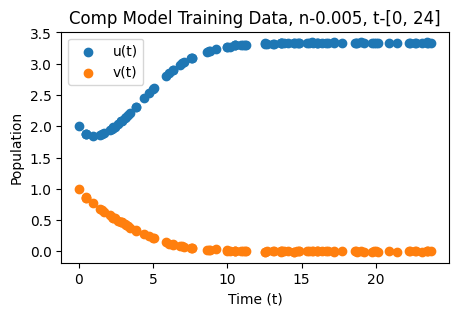

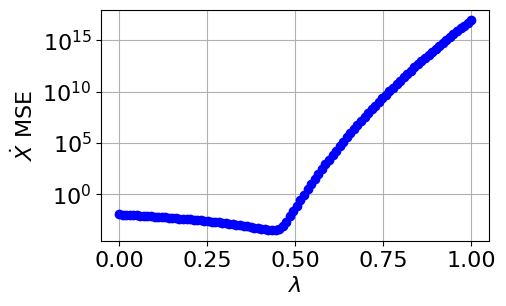

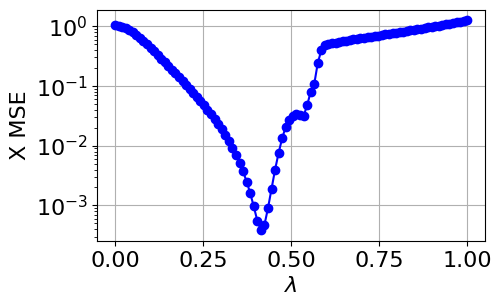

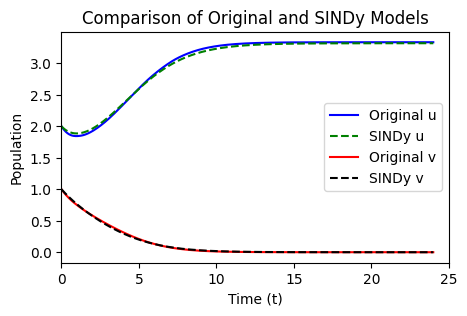

In [7]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [0, 24]
seed = 0
output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       save_path=plot_save_path,
                                                       seed = seed)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.41, thresholder='l2', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training [10, 24] noise = 0.005

0.10101010101010102 0.32323232323232326
(u)' = 0.600 u + -0.181 u^2 + 0.013 u v
(v)' = -0.014 v + -0.033 u v + 0.001 v^2
[0.5, 0.3, 0.6, 0.7, 0.3]
Coefficients exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[10, 24]\coefs_FD_0.005_100_[10, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_Surv_0.005_FD_100_500_[10, 24]\threshold_FD_0.005_100_[10, 24].csv


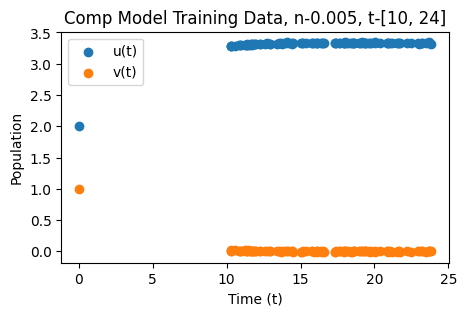

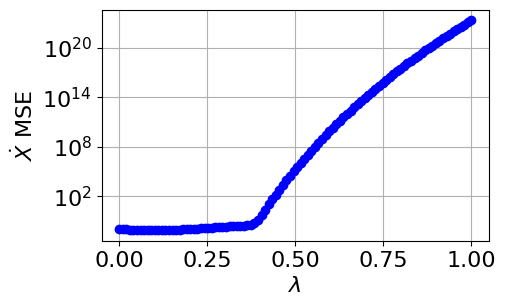

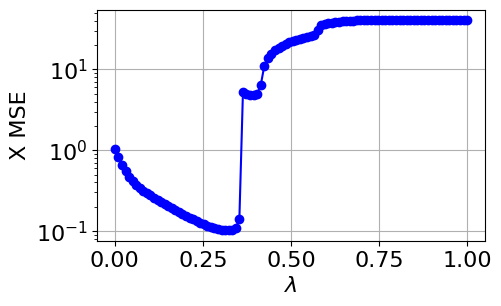

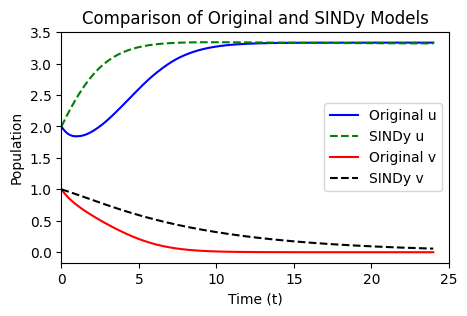

In [8]:
params = [0.5, 0.3, 0.6, 0.7, 0.3] 
tend = 24
numx = 100	
nTest = 500
initial_conditions = [2, 1]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [10, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_Surv_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=CompetitionModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=params, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       save_path=plot_save_path,
                                                       seed = seed)

max_threshold = 1  
num_threshold = 100
feature_names = ["u", "v"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

n_targets = 2
n_features = 5
constraint_rhs = np.asarray([1, 0, 0, 0, 0]) # 1st eq: u, v, v^2 and 2n eq: u, u^2
constraint_lhs = np.zeros((5, n_targets*n_features))
# in equation 1, 3rd term u^2 is 1
constraint_lhs[0, 0] = 1
constraint_lhs[1, 1] = 1
constraint_lhs[2, 4] = 1
constraint_lhs[3, n_features] = 1
constraint_lhs[4, n_features+2] = 1

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                                constraint_lhs=constraint_lhs,
                                threshold=threshold, thresholder='l2', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, 
                     feature_library=feature_library, 
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)
print(lambda_mse, lambda_mse_sim)

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.3, thresholder='l2', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=opt,
                 feature_library=feature_library, 
                 differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
print(params)
plot_models(tend, initial_conditions, params, CompetitionModel, model)

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

In [9]:
model.coefficients()

array([[ 6.00000000e-01,  3.86053076e-19, -1.80980396e-01,
         1.34011430e-02, -3.26778017e-21],
       [-4.33908866e-17, -1.36260617e-02,  1.65684868e-16,
        -3.28787526e-02,  1.25227096e-03]])